# Data here: 
## IPM Approach (2 profiles) 
## Sequential Approach (7 profiles) 

# Import Long Format 8760 

In [1]:
#importing packages needed for analysis
import os
import numpy as np
import pandas as pd
import math
from pandas import DataFrame

path = os.getcwd()
#print(path)

load_dur = pd.read_csv('../outputs/load_long_format.csv')
solar_dur = pd.read_csv('../outputs/solar_long_format.csv')
wind_dur = pd.read_csv('../outputs/wind_long_format.csv')

## UNCOMMENT WHICH PROFILE TO BE USED
x = load_dur
x_name = 'load'
x_name2 = 'Load'
x_column = 'Load'

#x = solar_dur
#x_name = 'solar'
#x_name2 = 'Solar_Gen'
#choose TRG 
#x_column = 'TRG6'

#x = wind_dur
#x_name = 'wind'
#x_name2 = 'Wind_Gen'
#x_column = 'TRG4'

#this code creates an output directory in the parent director, if one does not exist yet
#Note: this is where all of the output files will be written, since outputs are large this saves space in git
path = os.getcwd()
parent = os.path.dirname(path)
outputs_dir = parent+'\outputs'
if not os.path.exists(outputs_dir):
    os.makedirs(outputs_dir)
print('output files are written out in parent directory: '+outputs_dir)

outputs_x = outputs_dir+'/'+x_name
if not os.path.exists(outputs_x):
    os.makedirs(outputs_x)
print('output files are written out in parent directory: '+outputs_x)

#add an hour counter
x['Hour_Counter'] = (x['Hour']) + (x['Day'] - 1) * 24
x = x.sort_values(by=['Region','Hour_Counter'])
unique_hc = pd.Series(x['Hour_Counter'].unique()).dropna()
#print(unique_hc.tail(2))

#print(x)

output files are written out in parent directory: C:\Users\tgoforth\Documents\IPM temporal resolution project\outputs
output files are written out in parent directory: C:\Users\tgoforth\Documents\IPM temporal resolution project\outputs/load


# Case 1: Normal IPM Approach (72 Representative Hours)
### Details: Split into 3 seasons, then 6 groups, then 4 times of day
#### Methodology: Use counters to keep track of season split, then use groupby function to find load averages

In [2]:
#Assign the time of day (TOD) categories to hours

#Read in the time of day categories
tod = pd.read_csv('inputs/time_of_day.csv')
#print(tod)

#merge the time of data categories to the dataframe
x2 = pd.merge(x,tod,on='Hour',how='left')
x2 = x2.drop(x2.columns[0], axis=1)
x2 = x2[['Region','R_Group','R_Subgroup','Season','Month','Day','Hour','Hour_Counter','TOD',x_column]]
print()
print(x2.head(2))
print(x2.shape)


     Region R_Group R_Subgroup  Season  Month  Day  Hour  Hour_Counter    TOD  \
0  ERC_REST     ERC       REST  winter      1    1     1             1  night   
1  ERC_REST     ERC       REST  winter      1    1     2             2  night   

    Load  
0  34807  
1  34551  
(551880, 10)


In [3]:
#Assign the Group categories to season/hours

#Create a list of season to the 8760 hours
seasons = x2[x2['Region']==x2['Region'].iloc[0]]
seasons = seasons[['Season','Hour_Counter']]
print(seasons.head())
#print(seasons.shape)

#get the number of hours in each season
season_count = seasons.groupby('Season',as_index=False).count().rename(columns={'Hour_Counter':'Season_Tot'})
season_count = season_count.sort_values('Season')
#print(season_count)
#print()

#read in the group shares data
group = pd.read_csv('inputs/group_shares.csv')

#combined the group shares data with the season/hours data
#NOTE: if there are ever more than three seasons, this code should be updated
group[season_count.iloc[0,0]] = group['Share']*season_count.iloc[0,1]
group[season_count.iloc[1,0]] = group['Share']*season_count.iloc[1,1]
group[season_count.iloc[2,0]] = group['Share']*season_count.iloc[2,1]
group_sea = pd.melt(group,id_vars=['Group','Share'],var_name='Seasons',value_name='Season_Ct')
group_sea['Season_Counter'] = group_sea['Season_Ct'].cumsum()
group_sea['Season_Counter'] = round(group_sea['Season_Counter'])
#print(group.dtypes)
#print(group)
#print(group_sea)
#print()

#Create a dataframe with 8760 numbers
unique_hc = pd.Series(x['Hour_Counter'].unique()).dropna()
unique_hc = pd.DataFrame(unique_hc,columns=['Season_Counter'])
unique_hc['Season_Counter'] = unique_hc['Season_Counter']*1.0
season_8760 = pd.merge_asof(unique_hc, group_sea, on='Season_Counter', direction='forward')
print(unique_hc.tail())
print(season_8760)
#print(season_8760.shape)
#print()


   Season  Hour_Counter
0  winter             1
1  winter             2
2  winter             3
3  winter             4
4  winter             5
      Season_Counter
8755          8756.0
8756          8757.0
8757          8758.0
8758          8759.0
8759          8760.0
      Season_Counter  Group  Share   Seasons  Season_Ct
0                1.0      1   0.01  shoulder      29.28
1                2.0      1   0.01  shoulder      29.28
2                3.0      1   0.01  shoulder      29.28
3                4.0      1   0.01  shoulder      29.28
4                5.0      1   0.01  shoulder      29.28
...              ...    ...    ...       ...        ...
8755          8756.0      6   0.25    winter     540.00
8756          8757.0      6   0.25    winter     540.00
8757          8758.0      6   0.25    winter     540.00
8758          8759.0      6   0.25    winter     540.00
8759          8760.0      6   0.25    winter     540.00

[8760 rows x 5 columns]


In [4]:
#Assign the load group categories to each of the 8760 hours

x2 = x2.sort_values(['Region','Season',x_column], ascending=[True, True, False])
x2 = x2.reset_index(drop=True)
x2['Season_Counter'] = ( ( x2.index + 8760 ) % 8760 ) + 1
x2['Season_Counter'] = x2['Season_Counter'].astype(int)
#print(x2.head(2))
#print(x2.dtypes)

#Merge seasonal group data to the full dataframe
x3 = pd.merge(x2,season_8760,on='Season_Counter',how='left')
x3 = x3.drop(columns=['Share','Seasons','Season_Ct'])
print(x3)
print()
print(x3.tail(2))
print()
print('number of rows in dataset =',x3.shape[0])

          Region R_Group R_Subgroup    Season  Month  Day  Hour  Hour_Counter  \
0       ERC_REST     ERC       REST  shoulder     10  278    15          6663   
1       ERC_REST     ERC       REST  shoulder     10  278    14          6662   
2       ERC_REST     ERC       REST  shoulder     10  278    16          6664   
3       ERC_REST     ERC       REST  shoulder     10  291    15          6975   
4       ERC_REST     ERC       REST  shoulder     10  290    15          6951   
...          ...     ...        ...       ...    ...  ...   ...           ...   
551875  WEC_SDGE     WEC       SDGE    winter      1   30     4           700   
551876  WEC_SDGE     WEC       SDGE    winter      1   16     4           364   
551877  WEC_SDGE     WEC       SDGE    winter      1   17     4           388   
551878  WEC_SDGE     WEC       SDGE    winter      2   38     3           891   
551879  WEC_SDGE     WEC       SDGE    winter      1   17     3           387   

            TOD   Load  Sea

In [5]:
x3 = x3.sort_values(['Region','Season','Group','TOD'])

aggregations = {x_column:['count',sum,'mean']}
norm = x3.groupby(['Region','Season','Group','TOD'],as_index=False).agg(aggregations)
norm.columns = norm.columns.droplevel(0)
norm.columns = ['Region','Season','Group','TOD','Hour_Tot','Tot','Avg']
print(norm.head(3))
print('number of rows in dataset =',norm.shape[0])
norm.to_csv('../outputs/'+x_name+'/'+x_name+'_segments_NORM.csv')
print()

x4 = pd.merge(x3,norm,on=['Region','Season','Group','TOD'],how='left')
x4 = x4.sort_values(['Region',x_column])
print(x4.head(3))
print('number of rows in dataset =',x4.shape[0])
x4.to_csv('../outputs/'+x_name+'/'+x_name+'_8760_NORM.csv')


     Region    Season  Group      TOD  Hour_Tot      Tot           Avg
0  ERC_REST  shoulder      1  evening         2   107834  53917.000000
1  ERC_REST  shoulder      1  middday        27  1482630  54912.222222
2  ERC_REST  shoulder      2  evening        34  1693417  49806.382353
number of rows in dataset = 4169

        Region R_Group R_Subgroup    Season  Month  Day  Hour  Hour_Counter  \
2927  ERC_REST     ERC       REST  shoulder      3   86     3          2043   
2926  ERC_REST     ERC       REST  shoulder      4   94     2          2234   
2925  ERC_REST     ERC       REST  shoulder      3   72     3          1707   

        TOD   Load  Season_Counter  Group  Hour_Tot       Tot           Avg  
2927  night  26989            2928      6       661  19467771  29451.998487  
2926  night  27006            2927      6       661  19467771  29451.998487  
2925  night  27025            2926      6       661  19467771  29451.998487  
number of rows in dataset = 551880


KeyError: 'Load_Avg'

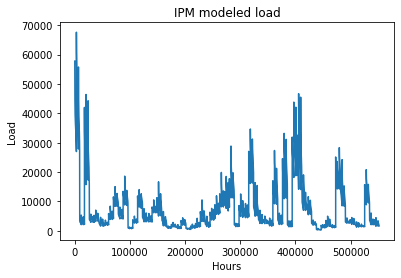

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

x4 = x4.sort_values(by=['Region','Season_Counter'])
plt.plot(x4[x_column].values)
plt.title('IPM modeled load')
plt.xlabel('Hours')
plt.ylabel(x_name2)

x4 = x4.sort_values(by=['Region','Season',x_name2+'_Avg'],ascending=[True, True, False])
plt.plot(x4[x_name2+'_Avg'].values)
plt.title(x_name2+' comparison')
plt.xlabel('hours')
plt.ylabel(x_name2)

plt.show()

In [ ]:
fig, axis = plt.subplots()

axis.yaxis.grid(True)
axis.set_title(x_name2+' comparison')
axis.set_xlabel('modeled load')
axis.set_ylabel('actual load')

X = x4[x_name2+'_Avg']/1000
Y = x4[x_column]/1000

axis.scatter(X, Y)
plt.show()

# Case 2: Grouping Time of Day before Group
### Details: Regions will be split first by season, then time of day, then group
#### Methodology: Use same methods & code as norm case, but switch order of groupby for group and time of day

In [7]:
#Assign the time of day (TOD) categories to hours

#Read in the time of day categories
tod = pd.read_csv('inputs/time_of_day.csv')
#print(tod)

#merge the time of data categories to the dataframe
tod_x = pd.merge(x,tod,on='Hour',how='left')
tod_x = tod_x.drop(tod_x.columns[0],axis=1)
tod_x = tod_x[['Region','R_Group','R_Subgroup','Season','Month','Day','Hour','Hour_Counter','TOD',x_column]]
print()
print(tod_x.head(2))



     Region R_Group R_Subgroup  Season  Month  Day  Hour  Hour_Counter    TOD  \
0  ERC_REST     ERC       REST  winter      1    1     1             1  night   
1  ERC_REST     ERC       REST  winter      1    1     2             2  night   

    Load  
0  34807  
1  34551  


In [8]:
#Assign the Group categories to season/hours

#Create a list of season to the 8760 hours
seasons2 = tod_x[tod_x['Region']==tod_x['Region'].iloc[0]]
seasons2 = seasons2[['Season','Hour_Counter']]
#print(seasons2.head())
#print(seasons2.shape)

#get the number of hours in each season
season2_count = seasons2.groupby('Season',as_index=False).count().rename(columns={'Hour_Counter':'Season_Tot'})
season2_count = season2_count.sort_values('Season')
#print(season2_count)
#print()

#read in the group shares data
group3 = pd.read_csv('inputs/group_shares.csv')

#combined the group shares data with the season/hours data
#NOTE: if there are ever more than three seasons, this code should be updated
group3[season2_count.iloc[0,0]] = group3['Share']*season2_count.iloc[0,1]
group3[season2_count.iloc[1,0]] = group3['Share']*season2_count.iloc[1,1]
group3[season2_count.iloc[2,0]] = group3['Share']*season2_count.iloc[2,1]
group2_sea = pd.melt(group3,id_vars=['Group','Share'],var_name='Seasons',value_name='Season_Ct')
group2_sea['Season_Counter'] = group2_sea['Season_Ct'].cumsum()
group2_sea['Season_Counter'] = round(group2_sea['Season_Counter'])
#print(group.dtypes)
#print(group)
#print(group_sea)
#print()

#Create a dataframe with 8760 numbers
unique_hc2 = pd.Series(x['Hour_Counter'].unique()).dropna()
unique_hc2 = pd.DataFrame(unique_hc2,columns=['Season_Counter'])
unique_hc2['Season_Counter'] = unique_hc2['Season_Counter']*1.0
season2_8760 = pd.merge_asof(unique_hc2, group2_sea, on='Season_Counter', direction='forward')
#print(unique_hc.tail())
#print(season_8760.tail(3))
#print(season_8760.shape)
#print()

In [9]:
#Assign the load group categories to each of the 8760 hours

#Create the seasonal counter in the load dataset to merge with
tod_x = tod_x.sort_values(['Region','Season',x_column], ascending=[True, True, False])
tod_x = tod_x.reset_index(drop=True)
tod_x['Season_Counter'] = ( ( tod_x.index + 8760 ) % 8760 ) + 1
tod_x['Season_Counter'] = tod_x['Season_Counter'].astype(int)
#print(tod_x.head(2))
#print(tod_x.dtypes)

#Merge seasonal group data to the full dataframe
tod_x_2 = pd.merge(tod_x,season2_8760,on='Season_Counter',how='left')
tod_x_2 = tod_x_2.drop(columns=['Share','Seasons','Season_Ct'])
print(tod_x_2.head(2))
print()
print(tod_x_2.tail(2))
print()
print('number of rows in dataset =',tod_x_2.shape[0])

     Region R_Group R_Subgroup    Season  Month  Day  Hour  Hour_Counter  \
0  ERC_REST     ERC       REST  shoulder     10  278    15          6663   
1  ERC_REST     ERC       REST  shoulder     10  278    14          6662   

       TOD   Load  Season_Counter  Group  
0  middday  57777               1      1  
1  middday  57380               2      1  

          Region R_Group R_Subgroup  Season  Month  Day  Hour  Hour_Counter  \
551878  WEC_SDGE     WEC       SDGE  winter      2   38     3           891   
551879  WEC_SDGE     WEC       SDGE  winter      1   17     3           387   

          TOD  Load  Season_Counter  Group  
551878  night  1703            8759      6  
551879  night  1697            8760      6  

number of rows in dataset = 551880


In [10]:
tod_x_2 = tod_x_2.sort_values(['Region','Season','TOD','Group'])

aggregations = {x_column:['count',sum,'mean']}
case2 = tod_x_2.groupby(['Region','Season','TOD','Group'],as_index=False).agg(aggregations)
case2.columns = case2.columns.droplevel(0)
case2.columns = ['Region','Season','TOD','Group','Hour_Tot','Tot','Avg']
print(case2.head(3))
print('number of rows in dataset =',case2.shape[0])
case2.to_csv('../outputs/'+x_name+'/'+x_name+'_segments_timeofday.csv')
print()

tod_x_3 = pd.merge(tod_x_2,case2,on=['Region','Season','TOD','Group'],how='left')
tod_x_3 = tod_x_3.sort_values(['Region',x_column])
print(tod_x_3.head(3))
print('number of rows in dataset =',tod_x_3.shape[0])
tod_x_3.to_csv('../outputs/'+x_name+'/'+x_name+'_8760_timeofday.csv')


     Region    Season      TOD  Group  Hour_Tot      Tot           Avg
0  ERC_REST  shoulder  evening      1         2   107834  53917.000000
1  ERC_REST  shoulder  evening      2        34  1693417  49806.382353
2  ERC_REST  shoulder  evening      3        76  3345487  44019.565789
number of rows in dataset = 4169

        Region R_Group R_Subgroup    Season  Month  Day  Hour  Hour_Counter  \
2927  ERC_REST     ERC       REST  shoulder      3   86     3          2043   
2926  ERC_REST     ERC       REST  shoulder      4   94     2          2234   
2925  ERC_REST     ERC       REST  shoulder      3   72     3          1707   

        TOD   Load  Season_Counter  Group  Hour_Tot       Tot           Avg  
2927  night  26989            2928      6       661  19467771  29451.998487  
2926  night  27006            2927      6       661  19467771  29451.998487  
2925  night  27025            2926      6       661  19467771  29451.998487  
number of rows in dataset = 551880


### Plot of a single region

In [ ]:
#plot when testing a single region 
%matplotlib inline
import matplotlib.pyplot as plt

tod_x_3 = tod_x_3.sort_values(by=['Region','Season_Counter'])
plt.plot(tod_x_3[x_column].values)
plt.title('IPM modeled load')
plt.xlabel('Hours')
plt.ylabel(x_name2)

tod_x_3 = tod_x_3.sort_values(by=['Region','Season','Avg'],ascending=[True, True, False])
plt.plot(tod_x_3['Avg'].values)
plt.title(x_name2+' comparison')
plt.xlabel('hours')
plt.ylabel(x_column)

plt.show()

# Sequential Approach 
### Details: Split into different hour intervals (2, 4, 8, 12, 24, 48, 120) to test the accuracy of the load estimations
#### Methodology: use a single csv numbered from 1 to 8760 to identify the groups that each hour will go in 

In [11]:
#load useful info into notebook
seq_x = x.copy()
seq_intervals = pd.read_csv('inputs/sequential_hours.csv')

#### 2 hour interval

In [12]:
#start with 2 hour interval
seq_2hr = seq_x.copy()
seq_2hr = pd.merge(seq_2hr, seq_intervals, on='Hour_Counter', how='left')
seq_2hr = seq_2hr.drop(seq_2hr.columns[0], axis=1)
seq_2hr = seq_2hr.drop(columns=['4-hr','8-hr','12-hr','24-hr','48-hr','120-hr'])
#print(seq_2hr)

#average load based on order of groups
aggregations = {x_column:['count',sum,'mean']}
case_2hr = seq_2hr.groupby(['Region','2-hr'],as_index=False).agg(aggregations)
case_2hr.columns = case_2hr.columns.droplevel(0)
case_2hr.columns = ['Region','2-hr','Hour_Tot','Tot','Avg']
#print(case_2hr.head())
#print('number of rows in dataset =',case_2hr.shape[0])
case_2hr.to_csv('../outputs/'+x_name+'/'+x_name+'_segments_seq_2hr.csv')
#print()

seq_2hr_2 = pd.merge(seq_2hr,case_2hr,on=['Region','2-hr'],how='left')
seq_2hr_2 = seq_2hr_2.sort_values(['Region',x_column]).reset_index(drop=True)
print(seq_2hr_2)
print('number of rows in dataset =',seq_2hr_2.shape[0])
seq_2hr_2.to_csv('../outputs/'+x_name+'/'+x_name+'_8760_seq_2hr.csv')

          Region R_Group R_Subgroup    Season  Month  Day  Hour   Load  \
0       ERC_REST     ERC       REST  shoulder      3   86     3  26989   
1       ERC_REST     ERC       REST  shoulder      4   94     2  27006   
2       ERC_REST     ERC       REST  shoulder      3   72     3  27025   
3       ERC_REST     ERC       REST  shoulder      3   65     3  27059   
4       ERC_REST     ERC       REST  shoulder      3   65     2  27069   
...          ...     ...        ...       ...    ...  ...   ...    ...   
551875  WEC_SDGE     WEC       SDGE    summer      9  249    17   4434   
551876  WEC_SDGE     WEC       SDGE    summer      9  250    14   4446   
551877  WEC_SDGE     WEC       SDGE    summer      9  250    17   4465   
551878  WEC_SDGE     WEC       SDGE    summer      9  250    15   4470   
551879  WEC_SDGE     WEC       SDGE    summer      9  250    16   4479   

        Hour_Counter  2-hr  Hour_Tot    Tot      Avg  
0               2043  1022         2  54260  27130.0  
1

#### 4 hour interval

In [13]:
seq_4hr = seq_x.copy()
seq_4hr = pd.merge(seq_4hr, seq_intervals, on='Hour_Counter', how='left')
seq_4hr = seq_4hr.drop(seq_4hr.columns[0], axis=1)
seq_4hr = seq_4hr.drop(columns=['2-hr','8-hr','12-hr','24-hr','48-hr','120-hr'])
#print(seq_4hr)

#average load based on order of groups
aggregations = {x_column:['count',sum,'mean']}
case_4hr = seq_4hr.groupby(['Region','4-hr'],as_index=False).agg(aggregations)
case_4hr.columns = case_4hr.columns.droplevel(0)
case_4hr.columns = ['Region','4-hr','Hour_Tot','Tot','Avg']
#print(case_4hr.head())
#print('number of rows in dataset =',case_4hr.shape[0])
case_4hr.to_csv('../outputs/'+x_name+'/'+x_name+'_segments_seq_4hr.csv')
#print()

seq_4hr_2 = pd.merge(seq_4hr,case_4hr,on=['Region','4-hr'],how='left')
seq_4hr_2 = seq_4hr_2.sort_values(['Region',x_column]).reset_index(drop=True)
print(seq_4hr_2)
print('number of rows in dataset =',seq_4hr_2.shape[0])
seq_4hr_2.to_csv('../outputs/'+x_name+'/'+x_name+'_8760_seq_4hr.csv')

          Region R_Group R_Subgroup    Season  Month  Day  Hour   Load  \
0       ERC_REST     ERC       REST  shoulder      3   86     3  26989   
1       ERC_REST     ERC       REST  shoulder      4   94     2  27006   
2       ERC_REST     ERC       REST  shoulder      3   72     3  27025   
3       ERC_REST     ERC       REST  shoulder      3   65     3  27059   
4       ERC_REST     ERC       REST  shoulder      3   65     2  27069   
...          ...     ...        ...       ...    ...  ...   ...    ...   
551875  WEC_SDGE     WEC       SDGE    summer      9  249    17   4434   
551876  WEC_SDGE     WEC       SDGE    summer      9  250    14   4446   
551877  WEC_SDGE     WEC       SDGE    summer      9  250    17   4465   
551878  WEC_SDGE     WEC       SDGE    summer      9  250    15   4470   
551879  WEC_SDGE     WEC       SDGE    summer      9  250    16   4479   

        Hour_Counter  4-hr  Hour_Tot     Tot       Avg  
0               2043   511         4  108862  27215.50

#### 8 hour interval

In [14]:
seq_8hr = seq_x.copy()
seq_8hr = pd.merge(seq_8hr, seq_intervals, on='Hour_Counter', how='left')
seq_8hr = seq_8hr.drop(seq_8hr.columns[0], axis=1)
seq_8hr = seq_8hr.drop(columns=['2-hr','4-hr','12-hr','24-hr','48-hr','120-hr'])
#print(seq_8hr)

#average based on order of groups
aggregations = {x_column:['count',sum,'mean']}
case_8hr = seq_8hr.groupby(['Region','8-hr'],as_index=False).agg(aggregations)
case_8hr.columns = case_8hr.columns.droplevel(0)
case_8hr.columns = ['Region','8-hr','Hour_Tot','Tot','Avg']
#print(case_8hr.head())
#print('number of rows in dataset =',case_8hr.shape[0])
case_8hr.to_csv('../outputs/'+x_name+'/'+x_name+'_segments_seq_8hr.csv')
#print()

seq_8hr_2 = pd.merge(seq_8hr,case_8hr,on=['Region','8-hr'],how='left')
seq_8hr_2 = seq_8hr_2.sort_values(['Region',x_column]).reset_index(drop=True)
print(seq_8hr_2)
print('number of rows in dataset =',seq_8hr_2.shape[0])
seq_8hr_2.to_csv('../outputs/'+x_name+'/'+x_name+'_8760_seq_8hr.csv')

          Region R_Group R_Subgroup    Season  Month  Day  Hour   Load  \
0       ERC_REST     ERC       REST  shoulder      3   86     3  26989   
1       ERC_REST     ERC       REST  shoulder      4   94     2  27006   
2       ERC_REST     ERC       REST  shoulder      3   72     3  27025   
3       ERC_REST     ERC       REST  shoulder      3   65     3  27059   
4       ERC_REST     ERC       REST  shoulder      3   65     2  27069   
...          ...     ...        ...       ...    ...  ...   ...    ...   
551875  WEC_SDGE     WEC       SDGE    summer      9  249    17   4434   
551876  WEC_SDGE     WEC       SDGE    summer      9  250    14   4446   
551877  WEC_SDGE     WEC       SDGE    summer      9  250    17   4465   
551878  WEC_SDGE     WEC       SDGE    summer      9  250    15   4470   
551879  WEC_SDGE     WEC       SDGE    summer      9  250    16   4479   

        Hour_Counter  8-hr  Hour_Tot     Tot        Avg  
0               2043   256         8  227259  28407.3

#### 12 hour interval

In [15]:
seq_12hr = seq_x.copy()
seq_12hr = pd.merge(seq_12hr, seq_intervals, on='Hour_Counter', how='left')
seq_12hr = seq_12hr.drop(seq_12hr.columns[0], axis=1)
seq_12hr = seq_12hr.drop(columns=['2-hr','4-hr','8-hr','24-hr','48-hr','120-hr'])
#print(seq_12hr)

#average based on order of groups
aggregations = {x_column:['count',sum,'mean']}
case_12hr = seq_12hr.groupby(['Region','12-hr'],as_index=False).agg(aggregations)
case_12hr.columns = case_12hr.columns.droplevel(0)
case_12hr.columns = ['Region','12-hr','Hour_Tot','Tot','Avg']
#print(case_12hr.head())
#print('number of rows in dataset =',case_12hr.shape[0])
case_12hr.to_csv('../outputs/'+x_name+'/'+x_name+'_segments_seq_12hr.csv')
#print()

seq_12hr_2 = pd.merge(seq_12hr,case_12hr,on=['Region','12-hr'],how='left')
seq_12hr_2 = seq_12hr_2.sort_values(['Region',x_column]).reset_index(drop=True)
print(seq_12hr_2)
print('number of rows in dataset =',seq_12hr_2.shape[0])
seq_12hr_2.to_csv('../outputs/'+x_name+'/'+x_name+'_8760_seq_12hr.csv')

          Region R_Group R_Subgroup    Season  Month  Day  Hour   Load  \
0       ERC_REST     ERC       REST  shoulder      3   86     3  26989   
1       ERC_REST     ERC       REST  shoulder      4   94     2  27006   
2       ERC_REST     ERC       REST  shoulder      3   72     3  27025   
3       ERC_REST     ERC       REST  shoulder      3   65     3  27059   
4       ERC_REST     ERC       REST  shoulder      3   65     2  27069   
...          ...     ...        ...       ...    ...  ...   ...    ...   
551875  WEC_SDGE     WEC       SDGE    summer      9  249    17   4434   
551876  WEC_SDGE     WEC       SDGE    summer      9  250    14   4446   
551877  WEC_SDGE     WEC       SDGE    summer      9  250    17   4465   
551878  WEC_SDGE     WEC       SDGE    summer      9  250    15   4470   
551879  WEC_SDGE     WEC       SDGE    summer      9  250    16   4479   

        Hour_Counter  12-hr  Hour_Tot     Tot           Avg  
0               2043    171        12  358408  29

#### 24 hour interval

In [16]:
seq_24hr = seq_x.copy()
seq_24hr = pd.merge(seq_24hr, seq_intervals, on='Hour_Counter', how='left')
seq_24hr = seq_24hr.drop(seq_24hr.columns[0], axis=1)
seq_24hr = seq_24hr.drop(columns=['2-hr','4-hr','8-hr','12-hr','48-hr','120-hr'])
#print(seq_24hr)

#average based on order of groups
aggregations = {x_column:['count',sum,'mean']}
case_24hr = seq_24hr.groupby(['Region','24-hr'],as_index=False).agg(aggregations)
case_24hr.columns = case_24hr.columns.droplevel(0)
case_24hr.columns = ['Region','24-hr','Hour_Tot','Tot','Avg']
#print(case_24hr.head())
#print('number of rows in dataset =',case_24hr.shape[0])
case_24hr.to_csv('../outputs/'+x_name+'/'+x_name+'_segments_seq_24hr.csv')
#print()

seq_24hr_2 = pd.merge(seq_24hr,case_24hr,on=['Region','24-hr'],how='left')
seq_24hr_2 = seq_24hr_2.sort_values(['Region',x_column]).reset_index(drop=True)
print(seq_24hr_2)
print('number of rows in dataset =',seq_24hr_2.shape[0])
seq_24hr_2.to_csv('../outputs/'+x_name+'/'+x_name+'_8760_seq_24hr.csv')

          Region R_Group R_Subgroup    Season  Month  Day  Hour   Load  \
0       ERC_REST     ERC       REST  shoulder      3   86     3  26989   
1       ERC_REST     ERC       REST  shoulder      4   94     2  27006   
2       ERC_REST     ERC       REST  shoulder      3   72     3  27025   
3       ERC_REST     ERC       REST  shoulder      3   65     3  27059   
4       ERC_REST     ERC       REST  shoulder      3   65     2  27069   
...          ...     ...        ...       ...    ...  ...   ...    ...   
551875  WEC_SDGE     WEC       SDGE    summer      9  249    17   4434   
551876  WEC_SDGE     WEC       SDGE    summer      9  250    14   4446   
551877  WEC_SDGE     WEC       SDGE    summer      9  250    17   4465   
551878  WEC_SDGE     WEC       SDGE    summer      9  250    15   4470   
551879  WEC_SDGE     WEC       SDGE    summer      9  250    16   4479   

        Hour_Counter  24-hr  Hour_Tot     Tot           Avg  
0               2043     86        24  748721  31

#### 48 hour interval

In [17]:
seq_48hr = seq_x.copy()
seq_48hr = pd.merge(seq_48hr, seq_intervals, on='Hour_Counter', how='left')
seq_48hr = seq_48hr.drop(seq_48hr.columns[0], axis=1)
seq_48hr = seq_48hr.drop(columns=['2-hr','4-hr','8-hr','12-hr','24-hr','120-hr'])
#print(seq_48hr)

#average load based on order of groups
aggregations = {x_column:['count',sum,'mean']}
case_48hr = seq_48hr.groupby(['Region','48-hr'],as_index=False).agg(aggregations)
case_48hr.columns = case_48hr.columns.droplevel(0)
case_48hr.columns = ['Region','48-hr','Hour_Tot','Tot','Avg']
#print(case_48hr.head())
#print('number of rows in dataset =',case_48hr.shape[0])
case_48hr.to_csv('../outputs/'+x_name+'/'+x_name+'_segments_seq_48hr.csv')
#print()

seq_48hr_2 = pd.merge(seq_48hr,case_48hr,on=['Region','48-hr'],how='left')
seq_48hr_2 = seq_48hr_2.sort_values(['Region',x_column]).reset_index(drop=True)
print(seq_48hr_2)
print('number of rows in dataset =',seq_48hr_2.shape[0])
seq_48hr_2.to_csv('../outputs/'+x_name+'/'+x_name+'_8760_seq_48hr.csv')

          Region R_Group R_Subgroup    Season  Month  Day  Hour   Load  \
0       ERC_REST     ERC       REST  shoulder      3   86     3  26989   
1       ERC_REST     ERC       REST  shoulder      4   94     2  27006   
2       ERC_REST     ERC       REST  shoulder      3   72     3  27025   
3       ERC_REST     ERC       REST  shoulder      3   65     3  27059   
4       ERC_REST     ERC       REST  shoulder      3   65     2  27069   
...          ...     ...        ...       ...    ...  ...   ...    ...   
551875  WEC_SDGE     WEC       SDGE    summer      9  249    17   4434   
551876  WEC_SDGE     WEC       SDGE    summer      9  250    14   4446   
551877  WEC_SDGE     WEC       SDGE    summer      9  250    17   4465   
551878  WEC_SDGE     WEC       SDGE    summer      9  250    15   4470   
551879  WEC_SDGE     WEC       SDGE    summer      9  250    16   4479   

        Hour_Counter  48-hr  Hour_Tot      Tot           Avg  
0               2043     43        48  1506106  

#### 120 hour interval

In [18]:
seq_120hr = seq_x.copy()
seq_120hr = pd.merge(seq_120hr, seq_intervals, on='Hour_Counter', how='left')
seq_120hr = seq_120hr.drop(seq_120hr.columns[0], axis=1)
seq_120hr = seq_120hr.drop(columns=['2-hr','4-hr','8-hr','12-hr','24-hr','48-hr'])
#print(seq_120hr)

#average load based on order of groups
aggregations = {x_column:['count',sum,'mean']}
case_120hr = seq_120hr.groupby(['Region','120-hr'],as_index=False).agg(aggregations)
case_120hr.columns = case_120hr.columns.droplevel(0)
case_120hr.columns = ['Region','120-hr','Hour_Tot','Tot','Avg']
#print(case_120hr.head())
#print('number of rows in dataset =',case_120hr.shape[0])
case_120hr.to_csv('../outputs/'+x_name+'/'+x_name+'_segments_seq_120hr.csv')
#print()

seq_120hr_2 = pd.merge(seq_120hr,case_120hr,on=['Region','120-hr'],how='left')
seq_120hr_2 = seq_120hr_2.sort_values(['Region',x_column]).reset_index(drop=True)
print(seq_120hr_2)
print('number of rows in dataset =',seq_120hr_2.shape[0])
seq_120hr_2.to_csv('../outputs/'+x_name+'/'+x_name+'_8760_seq_120hr.csv')

          Region R_Group R_Subgroup    Season  Month  Day  Hour   Load  \
0       ERC_REST     ERC       REST  shoulder      3   86     3  26989   
1       ERC_REST     ERC       REST  shoulder      4   94     2  27006   
2       ERC_REST     ERC       REST  shoulder      3   72     3  27025   
3       ERC_REST     ERC       REST  shoulder      3   65     3  27059   
4       ERC_REST     ERC       REST  shoulder      3   65     2  27069   
...          ...     ...        ...       ...    ...  ...   ...    ...   
551875  WEC_SDGE     WEC       SDGE    summer      9  249    17   4434   
551876  WEC_SDGE     WEC       SDGE    summer      9  250    14   4446   
551877  WEC_SDGE     WEC       SDGE    summer      9  250    17   4465   
551878  WEC_SDGE     WEC       SDGE    summer      9  250    15   4470   
551879  WEC_SDGE     WEC       SDGE    summer      9  250    16   4479   

        Hour_Counter  120-hr  Hour_Tot      Tot           Avg  
0               2043      18       120  4122052